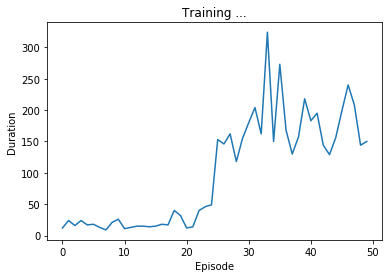

Complete


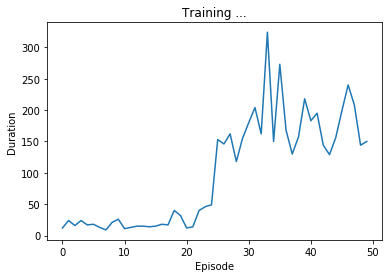

In [3]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is in use
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor


##########################
#
# Replay Memory
#
##########################

# Transition - a named tuple representing a single transition in our environment
# 这个元组是 DQN 算法要求的
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# ReplayMemory - a cyclic buffer of bounded size that holds the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


##########################################
#
# DQN Network -- Function Approximation
#
##########################################

class DQN(nn.Module):
    def __init__(self):
        # 这里的输入，将会是当前 screen 和之前一帧 screen 之间的差
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)  # 输入 channel 为 RGB，输出 channels 为 16
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        # 到这步时，Linear 层输入维度 flatten 之后为 448 维，这个是由输入的图像尺寸决定的
        # 输出为 2 维，分别标识不同动作下的 Action-Value Function : Q(input, left) / Q(input, right)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        # view is like reshape，故此把 batch_size 维度单独提出来，剩下的维度会 flatten 到第二个维度
        return self.head(x.view(x.size(0), -1))


#####################
#
# Input Extraction
#
# use torchvision package to extract and process rendered images from environment
#
#####################

resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])
# based on the code from gym
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # middle of cart


def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))    # transpose into torch order (CHW) from (HWC)
    screen = screen[:, 160:320]  # strip off the top and bottom of the screen
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)

    # strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).type(Tensor)

# 测试一下前面定义的函数是否能够正常运行；具体来说，就是抓取 screen 图像，展示出来
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.title('Example extracted screen')
plt.show()


############################
#
# Hyperparameters and utils
#
############################

BATCH_SIZE = 128
GAMMA = 0.999    # Q(S, A) 随 time-step 的衰减指数
EPS_START = 0.9  # epsilon-greedy 贪心算法下，为了能收敛，epsilon 需要衰减到最后完全的 greedy 算法
EPS_END = 0.005  # 那么开始 epsilon 为 0.9，最后衰减到 0.005，就是说基本上不去做随机了，接近完全 greedy 算法
EPS_DECAY = 200  # EPS = 0.005 + (0.9 - 0.005) * exp(-1 * time_step_done / 200)
                 # time_step 很小时，EPS 接近于 0.005 + (0.9 - 0.005) * 1 = 0.9；那么，随机为主
                 # time_step 很大时，EPS 接近于 0.005 + (0.9 - 0.005) * exp(-inf) = 0.005 + (0.9 - 0.005) * 0 = 0.005，贪心为主
model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())   # 比普通的 gradient descent 要效率高

memory = ReplayMemory(10000)    # 最多缓存 10000 个 time-step Transition

steps_done = 0    # time-step so far


# epsilon-greedy 算法的实现函数，用于根据 model 或者随机选择下一步动作
def select_action(state):
    global steps_done
    # toss a coin
    sample = random.random()
    eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    # 如果大于 eps，那么贪心，具体的就是把当前输入(screen 之差)传入 DQN Approximation，来计算输出
    # 根据输出的 Q(state, left) 和 Q(state, right) 的值，取大的，作为下一步的动作
    # volatile 标识 state 及其所有和 state 相关的变脸不参与做 grad，或者说本次计算只做 forward-pass
    if sample > eps:
        # DQN model 是有 batch_size 维度的，故此 max 在第二个维度上进行
        # 本函数只接收一个 state，而不是一个 batch，故此返回时，只返回 batch_size 为 1 的结果
        return model(Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    # 否则，随机
    else:
        return LongTensor([[random.randrange(2)]])    # 随机一个 0、1 代表左、右

# 记录每个 episode 的 durations，用于展示
episode_durations = []


def plot_durations():
    plt.figure(2)  # 创建一个窗口，编号为 2；因为上面已经创建过一个窗口了，这是第二个
    plt.clf()   # clear figure
    durations_t = torch.FloatTensor(episode_durations)
    plt.title("Training ...")
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())   # 把历史 duration 曲线画出来

    # 这里再画一个 100 episodes 的平均 durations
    if len(durations_t) >= 100:
        # 举个例子，目前有 102 个 episodes，那么 unfold(从第 1 个维度，每次取 100 个，步长为 1) 返回
        # 0，1，2， .... 99
        # 1，2，3， .... 100
        # 2，3，4， .... 101
        # 然后每 100 个取平均，然后把平均值展开为一个一维张量
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))   # 把 [0] * 99 和 means 连在一起，就是说 episode 没到 100 时，这个值就设为 0
        plt.plot(means.numpy())    # 这是因为要和上面的历史 episode durations 曲线对齐

    plt.pause(0.001)   # pause a bit so that plots are updated

    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())


#################################
#
# Algorithm - how DQN runs
#
#################################

last_sync = 0

def optimize_model():
    global last_sync
    # 由于 batch models，如果还没有采样过足够多的样本，就不会进行模型的更新
    if len(memory) < BATCH_SIZE:
        return

    # 一旦 memory 中有了足够的样本，那么抽出一个 batch
    transitions = memory.sample(BATCH_SIZE)
    # transitions 是 Transition 的数组
    # zip(*transitions) 就是 zip(Transition[0], Transition[1], ...) = [(Transition[0][0], Transition[1][0] ...), (Transition[0][1], Transition[1][1] ...), (....)]
    # Transition(*zip(*transitions)) = Transition((Transition[0][0], Transition[1][0] ...), (Transition[0][1], Transition[1][1] ...), (....))
    #                                = Transition(field1=(Transition[0][0], Transition[1][0] ...), field2=.....)
    # 就是说，得到了一个 Transition 对象，而每个 field 中的值是 batch 中各个元素该 field 值所组成的列表
    batch = Transition(*zip(*transitions))

    # 要过滤掉其中步入结束状态的元素，故此这里先生成一个 boolean 列表，看哪些元素不是步入结束状态的
    # 也就是说 next_state 不是 None 的。由上面一句，我们知道 batch.next_state 以及其他的 field 都是 batch 中各个元素 field 值的列表
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))

    # 设置这个变量以及其相关变量，不参与 backprop autograd
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state if s is not None]), volatile=True)

    # 其他变量
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # 计算 Q-target 根据 old 模型参数
    # 把 state_batch 扔到 model 里，应该会得到 left 和 right 两个动作对应的 Q(S, a) 值；
    # 然后使用实际的 action_batch 去做匹配 (聚合)，取出实际 action_batch 对应的那个 Q 值
    state_action_values = model(state_batch).gather(1, action_batch)  # 在第二个维度上做聚合，匹配 action_batch 对应的那个结果元素

    # 通过 old 模型参数计算 next_state 下的价值最大化的动作对应的 Q 值，off-policy，实践中可能 pick 到其他的动作，因为是 epsilon-greedy 选择动作
    # 首先把所有 Q 值初始化到 0，然后只对那些没有步入结束的状态计算 Q 值；也就是说，对于步入结束的状态，认为其下一步 Q 值为 0
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]  # 去 left 和 right Q 值中最大的那个

    # 那么，可以计算预期的奖励了，就是即时奖励 + 衰减的未来奖励
    next_state_values.volatile = False
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # 普通的 DQN 采取 Least Square error 和 Gradient Descent 来更新
    # 我们这里采取 Huber Loss 和 RMSprop 来更新
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    optimizer.zero_grad()
    loss.backward()

    # 更新模型；看到，这里是每一个 batch 更新一次模型参数
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


#################################
#
# Training Loop - put it all together
#
#################################

num_episodes = 50

for i_episode in range(num_episodes):
    # 每个 Episode 之前，先初始化环境和状态
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen

    # 从 0 开始循环下去，直到 episode 结束
    for t in count():
        # e-greedy 选择动作
        action = select_action(state)
        # action 是个 [1, 1] 的张量，其实就是一个动作；把动作扔到 gym 环境中去，取出结果
        # 我们只要知道当前动作的 reward 以及 episode 是否结束即可
        _, reward, done, _ = env.step(action[0, 0])
        reward = Tensor([reward])

        # 观察下一个状态
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            # 步入结束时，next_state = None 是这里规定的
            next_state = None

        memory.push(state, action, next_state, reward)

        state = next_state

        # 如果 memory 里不足 BATCH_SIZE 个状态，那么不会运行优化
        optimize_model()

        # 如果 episode 结束，那么绘制 duration plot
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
env.render(close=True)
env.close()
plt.ioff()
plt.show()
